# Data treatment and Neural Network Training using IPMA data
João Oliveira and Edgar Mendes

In [42]:
#-----------------------Imports



#Data request libraries
import requests
import json

#Math libraries
import matplotlib.pyplot as plt
import pydot
import ipyplot 
import numpy as np
import random

#Time libraries
from datetime import datetime, timedelta
import time
import pytz

#File management libraries
from io import BytesIO
import os
import shutil
from PIL import Image, ImageDraw
from collections import OrderedDict

#Progress bar libraries
from ipywidgets import IntProgress
from IPython.display import display

#Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn import svm
import tensorflow as tf
from tensorflow.keras import callbacks, models, layers, utils

#-----------------------Constantes

#Dados das estações

boxVianaDoCastelo, boxLeiria, boxAveiro, boxBeja, boxBraga, boxBraganca, boxCasteloBranco, boxPortalegre, boxPorto, boxSantarem, boxCoimbra, boxEvora, boxFaro, boxGuarda, boxLisboa, boxSetubal, boxVilaReal, boxViseu = ((570, 428, 770, 628), (574, 902, 774, 1102), (603, 687, 803, 887), (735, 1546, 935, 1746), (645, 463, 845, 663), (953, 401, 1153, 601), (817, 886, 1017, 1086), (829, 1012, 1029, 1212), (611, 562, 811, 762), (597, 1026, 797, 1226), (645, 792, 845, 992), (740, 1183, 940, 1383), (736, 1546, 936, 1746), (859, 712, 1059, 912), (513, 1149, 713, 1349), (559, 1193, 759, 1393), (770, 527, 970, 727), (740, 682, 940, 882))
idVianaDoCastelo, idLeiria, idAveiro, idBeja, idBraga, idBraganca, idCasteloBranco, idPortalegre, idPorto, idSantarem, idCoimbra, idEvora, idFaro, idGuarda, idLisboa, idSetubal, idVilaReal, idViseu = 1240610, 1210718, 1210702, 1200562, 6212124, 1200575, 1200570, 1200571, 1240903, 1210734, 1210707, 1200558, 1200554, 1210683, 7240919, 1210770, 1240566, 1240675
ids = np.array([1240610, 1210718, 1210702, 1200562, 6212124, 1200575, 1200570, 1200571, 1240903, 1210734, 1210707, 1200558, 1200554, 1210683, 7240919, 1210770, 1240566, 1240675])
station_box_dict = {idVianaDoCastelo: boxVianaDoCastelo, idLeiria: boxLeiria, idAveiro: boxAveiro, idBeja: boxBeja, idBraga: boxBraga, idBraganca: boxBraganca, idCasteloBranco: boxCasteloBranco, idPortalegre: boxPortalegre, idPorto: boxPorto, idSantarem: boxSantarem, idCoimbra: boxCoimbra, idEvora: boxEvora, idFaro: boxFaro, idGuarda: boxGuarda, idLisboa: boxLisboa, idSetubal: boxSetubal, idVilaReal: boxVilaReal, idViseu: boxViseu}
limit_dictionary = {key: 16 for key in range(101)}

#-----------------------Funções

#Data request functions

def get_data(url):
    response = requests.get(f"{url}")
    if response.status_code == 200:
        return response.json() #https://www.educative.io/answers/how-to-make-api-calls-in-python
    else:
        print(f"Hello there, there's a {response.status_code} error with your request.")
        
def normalize_precipitation_value(precipitation_value):
    return int(round((precipitation_value/240)*100,0)) #o valor normalizado ta a ser arredondado pq as pastas sao de valores inteiros. https://www.ipma.pt/pt/oclima/extremos.clima/ Vou usar o valor máximo aqui como referencia

def list_dataset_folders():
    folders = []
    folder_path = os.getcwd()
    for name in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, name)):
            if name.endswith("dataset"):
                folders.append(name)
    return folders

def remove_black_pixels(image):
    # Convert the image to RGBA mode (if it's not already in RGBA mode)
    image = image.convert("RGBA")
    # Get the pixel data as a list of tuples
    pixels = list(image.getdata())
    # Replace every black pixel with transparent
    new_pixels = []
    for pixel in pixels:
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            new_pixels.append((0, 0, 0, 0))
        else:
            new_pixels.append(pixel)
    # Create a new image with the same size and mode as the original image
    new_image = Image.new(image.mode, image.size)
    # Update the new image with the new pixel data
    new_image.putdata(new_pixels)
    # Return the new image
    return new_image

#Manage dictionaries and arrays

def dict_to_array1D(input_dict):
    # Create an empty list to hold the values
    output_array = np.empty(0)
    # Loop over each key-value pair in the dictionary
    for date_dict in input_dict.values():
        for value in date_dict.values():
            # Append the value to the output array
            output_array = np.append(output_array,value)
    # Return the output array
    return output_array

def array2D_to_array1D(array_2D):
    return np.ravel(array_2D)

def array1D_to_array2D(array_1D):
    array2D = np.empty(0)
    array2D = np.reshape(array_1D, (-1, 1))
    return array2D

#Dataset labels array management

def count_how_many_occurrences_of_each_value(arr):
    arr = array2D_to_array1D(arr)
    counts = {}
    for num in arr:
        if num in counts:
            counts[num] += 1
        else:
            counts[num] = 1
    ordered_counts = OrderedDict(sorted(counts.items()))
    return ordered_counts

def get_one_hour_ago():
    return (datetime.now() - timedelta(hours=1)).hour

def extract_hour_data(json_obj,objective_hour):    
    hour_data = []
    for date in json_obj:
        if objective_hour in json_obj[date]:
            hour_data.append(json_obj[date][objective_hour])
    return hour_data

#Manage images

def shift_image_down(image_path, shift_value):
    # Open the image
    image = Image.open(image_path)

    # Create a new image with the updated height
    new_image = Image.new(image.mode, (image.width, image.height))

    # Copy the original image onto the new image, shifted down
    new_image.paste(image, (0, shift_value))

    # Get the first row of the original image
    first_row = image.crop((0, 0, image.width, 1))

    # Paste the first row into the new rows
    for y in range(shift_value):
        new_image.paste(first_row, (0, y, image.width, y + 1))

    # Return the shifted and filled image
    return new_image

def shift_image_left(image_path, shift_value):
    # Open the image
    image = Image.open(image_path)
    
    # Create a new image with the updated width
    new_image = Image.new(image.mode, (image.width, image.height))

    # Copy the original image onto the new image, shifted to the left
    new_image.paste(image, (-shift_value, 0))

    # Get the last column of the original image
    last_column = image.crop((image.width - 1, 0, image.width, image.height))

    # Paste the last column into the new columns
    for x in range(image.width - shift_value, image.width):
        new_image.paste(last_column, (x, 0, x + 1, image.height))

    image.close()
    # Return the shifted and filled image
    return new_image

def shift_image_right(image_path, shift_value):
    # Open the image
    image = Image.open(image_path)
        
    # Create a new image with the updated width
    new_image = Image.new(image.mode, (image.width, image.height))

    # Copy the original image onto the new image, shifted to the right
    new_image.paste(image, (shift_value, 0))

    # Get the first column of the original image
    first_column = image.crop((0, 0, 1, image.height))

    # Paste the first column into the new columns
    for x in range(shift_value):
        new_image.paste(first_column, (x, 0, x + 1, image.height))

    image.close()
    # Return the shifted and filled image
    return new_image

def rotate_image(image_path, angle):
    # Open the image
    image = Image.open(image_path)

    # Rotate the image
    rotated_image = image.rotate(angle, expand=True)

    # Create a new image with RGBA mode and transparent background
    new_image = Image.new("RGBA", rotated_image.size, (0, 0, 0, 0))

    # Paste the rotated image onto the new image
    new_image.paste(rotated_image, (0, 0), rotated_image)

    #Resize image to 200x200
    new_image = new_image.resize((200,200))
    
    image.close()
    # Return the rotated and filled image
    return new_image

In [4]:
DADOS_ULTIMAS_3_HORAS = "https://api.ipma.pt/open-data/observation/meteorology/stations/obs-surface.geojson" #por exemplo se forem 9PM tem os dados entre 5PM e 7PM de hora a hora para todas as estações
local_tz = pytz.timezone('Europe/Lisbon') #Define o fuso horário local

def get_images_and_data_from_ipma():
    
    data = get_data(DADOS_ULTIMAS_3_HORAS)
    specific_datasets = list_dataset_folders()
    # Faz a requisição à apiEstacoes e à apiMeteo para obter as informações meteorológicas 
    final_result = {}
    for feature in data['features']:
        f.value+=1
        if feature['properties']['idEstacao']  in ids:
            station_data = feature['properties']
            id_estacao = station_data['idEstacao']
            # Converte a hora da estação para o fuso horário local
            date_time_utc = datetime.fromisoformat(station_data['time'])
            date_time = datetime.fromisoformat(station_data['time']).replace(tzinfo=pytz.utc).astimezone(local_tz)
            date_str, hour_str = date_time.strftime('%Y-%m-%d %H:%M').split()
            precipitation = station_data['precAcumulada']

            if date_str not in final_result:
                final_result[date_str] = {hour_str: precipitation}
            else:
                final_result[date_str][hour_str] = normalize_precipitation_value(max(0, precipitation))

            url_image = f"https://www.ipma.pt/resources.www/transf/radar/por/pcr-{date_time_utc.strftime('%Y-%m-%d')}T{date_time_utc.strftime('%H%M')}.png"
            response = requests.get(url_image)
            image_data = BytesIO(response.content)
            image = Image.open(image_data)
            #print(f"{url_image} ({hour_str}h)")
                    
            # remover os pixeis pretos 
            image = remove_black_pixels(image)
            
            # Cor-te da imagem
            region = image.crop(station_box_dict[id_estacao])
            image.close()
            for specific_dataset in specific_datasets:

                # verifica se a pasta id_estacao existe e cria se não existir
                if not os.path.exists(f"{specific_dataset}/images/{id_estacao}"):
                    os.makedirs(f"{specific_dataset}/images/{id_estacao}")

                # verifica se a pasta date_str existe e cria se não existir
                if not os.path.exists(f"{specific_dataset}/images/{id_estacao}/{date_str}"):
                    os.makedirs(f"{specific_dataset}/images/{id_estacao}/{date_str}")

                elif specific_dataset == 'dataset':
                    region.save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")
                    original_image_path = f"dataset/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png"

                elif specific_dataset == 'left_20px_shifted_dataset':        
                    shift_image_left(original_image_path, 20).save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")
                    left_shifted_image_path = f"left_20px_shifted_dataset/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png"

                elif specific_dataset == 'right_20px_shifted_dataset':        
                    shift_image_right(original_image_path, 20).save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")
                    right_shifted_image_path = f"right_20px_shifted_dataset/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png"

                elif specific_dataset == 'down_20px_shifted_dataset':
                    shift_image_down(original_image_path, 20).save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")
                    down_shifted_image_path = f"down_20px_shifted_dataset/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png"

                elif specific_dataset == 'rotated_1degree__left_20px_shifted_dataset':
                    rotate_image(left_shifted_image_path, 1).save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")

                elif specific_dataset == 'rotated_1degree__right_20px_shifted_dataset':
                    rotate_image(right_shifted_image_path, 1).save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")
                
                elif specific_dataset == 'rotated_1degree__down_20px_shifted_dataset':
                    rotate_image(down_shifted_image_path, 1).save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")

                elif specific_dataset == 'rotated_1degree_dataset':
                    rotate_image(original_image_path, 1).save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")

                # Verifica se o arquivo JSON para esta estação já existe, se não, cria o arquivo
                filename = f"{specific_dataset}/precipitation/{id_estacao}.json"
                if not os.path.isfile(filename):
                    with open(filename, 'w') as file:
                        json.dump({}, file)

                # Carrega o conteúdo do arquivo JSON para a variável "precipitation_data"
                with open(filename, 'r') as file:
                    precipitation_data = json.load(file)

                # Adiciona as informações meteorológicas ao arquivo JSON
                for date in final_result:
                    if date not in precipitation_data:
                        precipitation_data[date] = final_result[date]
                    else:
                        precipitation_data[date].update(final_result[date])

                # Escreve o conteúdo atualizado no arquivo JSON
                with open(filename, 'w') as file:
                    json.dump(precipitation_data, file, indent=4)
    print("Dados atualizados com sucesso!")

In [5]:
progress_bar_length = 495
f = IntProgress(min=0, max=progress_bar_length) # instantiate the bar
display(f) # display the bar
get_images_and_data_from_ipma()

IntProgress(value=0, max=495)

Dados atualizados com sucesso!


# Data treatment

In [17]:
def modify_dictionary_values(dictionary):
    modified_dict = {}
    for key, value in dictionary.items():
        modified_dict[key] = min(value, 30)
    return modified_dict

def create_zero_dict(input_dict):
    zero_dict = {key: 0 for key in input_dict} #cria um dicionario onde as chaves são as mesmas do dicionario que recebeu mas o value é 0 em todas
    return zero_dict



In [43]:
counter_dictionary = {key: 0 for key in range(101)}
specific_datasets = list_dataset_folders()


data_array = np.empty(0)
images_array = np.empty((0, image_size, image_size, 4))

np.random.shuffle(specific_datasets)
np.random.shuffle(ids)

for dataset in specific_datasets:
    for stationID in ids:
    #json
        currentDir = dataset+'/precipitation/'+str(stationID)+'.json'
        with open(currentDir) as f:
            # Load the JSON data
            data = json.load(f)
        f.close()
        for date, hours in data.items():
            for hour in hours:
                variable = date + 'T' + hour.replace(':', '') + '.png'
                value = data[date][hour]
                if counter_dictionary[value] < limit_dictionary[value]:
                    counter_dictionary[value] += 1
                    data_array = np.append(data_array, value)
                    print(dataset+'/images/'+str(stationID)+'/'+date+'/'+variable)
                    image = Image.open(dataset+'/images/'+str(stationID)+'/'+date+'/'+variable)
                    img_np = np.array(image)
                    image.close()
                    images_array = np.append(images_array,[img_np], axis=0) #NAO TIRAR PARENTESIS RETOS!!!!!!!!!!!!!!



right_20px_shifted_dataset/images/1200571/2023-04-07/2023-04-07T2100.png
right_20px_shifted_dataset/images/1200571/2023-04-07/2023-04-07T2200.png
right_20px_shifted_dataset/images/1200571/2023-04-07/2023-04-07T2300.png
right_20px_shifted_dataset/images/1200571/2023-04-11/2023-04-11T0700.png
right_20px_shifted_dataset/images/1200571/2023-04-11/2023-04-11T0800.png
right_20px_shifted_dataset/images/1200571/2023-04-11/2023-04-11T0900.png
right_20px_shifted_dataset/images/1200571/2023-04-11/2023-04-11T1300.png
right_20px_shifted_dataset/images/1200571/2023-04-11/2023-04-11T1400.png
right_20px_shifted_dataset/images/1200571/2023-04-11/2023-04-11T1500.png
right_20px_shifted_dataset/images/1200571/2023-04-11/2023-04-11T1800.png
right_20px_shifted_dataset/images/1200571/2023-04-11/2023-04-11T1900.png
right_20px_shifted_dataset/images/1200571/2023-04-11/2023-04-11T2000.png
right_20px_shifted_dataset/images/1200571/2023-04-13/2023-04-13T1100.png
right_20px_shifted_dataset/images/1200571/2023-04-1


#  Model Training

In [44]:
# perm = np.random.permutation(len(data_array))
# images_array, data_array = images_array[perm], data_array[perm]

train_images, val_images, train_values, val_values = train_test_split(images_array, data_array, test_size=0.4, random_state=42)

train_images = tf.keras.utils.normalize(train_images, axis=1)
val_images = tf.keras.utils.normalize(val_images, axis=1)

print("How many of each value in train:")
print(count_how_many_occurrences_of_each_value(train_values))
print("How many of each value in validation:")
print(count_how_many_occurrences_of_each_value(val_values))


How many of each value in train:
OrderedDict([(0.0, 7), (1.0, 11), (2.0, 11), (3.0, 6), (5.0, 3)])
How many of each value in validation:
OrderedDict([(0.0, 9), (1.0, 5), (2.0, 5), (3.0, 2), (5.0, 5)])


In [45]:
#Valores da rede neuronal
 
n_channels = 4 
n_classes = 100 
n_neuronios = 16
filter_size = 3 
max_pool_size = (2,2) 
n_epochs = 100 
n_strides = 1
dropout_value = 0.4
image_size = 200

model = models.Sequential()
model.add(layers.Conv2D(n_neuronios, max_pool_size, activation='relu', input_shape=(image_size, image_size, n_channels)))
model.add(layers.Conv2D(n_neuronios, filter_size, strides=n_strides, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_value))
model.add(layers.MaxPooling2D(pool_size=max_pool_size))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(n_neuronios*2, filter_size, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(n_neuronios*4, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_value))
model.add(layers.Dense(n_classes, activation='softmax'))

#model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False, verbose=1, start_from_epoch=30) #Stop training when a monitored metric has stopped improving
model_checkpoint = callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=0, mode='max', save_weights_only=True) #Callback to save the Keras model or model weights at some frequency
#reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.01, cooldown=0, min_lr=0) #Reduce learning rate when a metric has stopped improving
terminate_on_nan = callbacks.TerminateOnNaN() #Callback that terminates training when a NaN (Not-a-number) loss is encountered

#load best weights
try:
    model.load_weights('best_model.h5')
    print("Weights loaded")
finally:
    #train the model with the callbacks
    history = model.fit(train_images, train_values, epochs= n_epochs, validation_data=(val_images, val_values), callbacks=[early_stopping, model_checkpoint, terminate_on_nan], verbose=1)

Epoch 1/100
2/2 [==============================] - 5s 1s/step - loss: 4.6975 - accuracy: 0.1053 - val_loss: 4.4216 - val_accuracy: 0.2308
Epoch 2/100
2/2 [==============================] - 2s 1s/step - loss: 3.1396 - accuracy: 0.3947 - val_loss: 4.3554 - val_accuracy: 0.3462
Epoch 3/100
2/2 [==============================] - 2s 500ms/step - loss: 2.9942 - accuracy: 0.4211 - val_loss: 4.3542 - val_accuracy: 0.3462
Epoch 4/100
2/2 [==============================] - 2s 509ms/step - loss: 2.7896 - accuracy: 0.5000 - val_loss: 4.3303 - val_accuracy: 0.3462
Epoch 5/100
2/2 [==============================] - 2s 495ms/step - loss: 2.5026 - accuracy: 0.6053 - val_loss: 4.3031 - val_accuracy: 0.3462
Epoch 6/100
2/2 [==============================] - 2s 506ms/step - loss: 2.6201 - accuracy: 0.5000 - val_loss: 4.2749 - val_accuracy: 0.3462
Epoch 7/100
2/2 [==============================] - 2s 542ms/step - loss: 2.3558 - accuracy: 0.6316 - val_loss: 4.2464 - val_accuracy: 0.3462
Epoch 8/100
2/2 [==

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

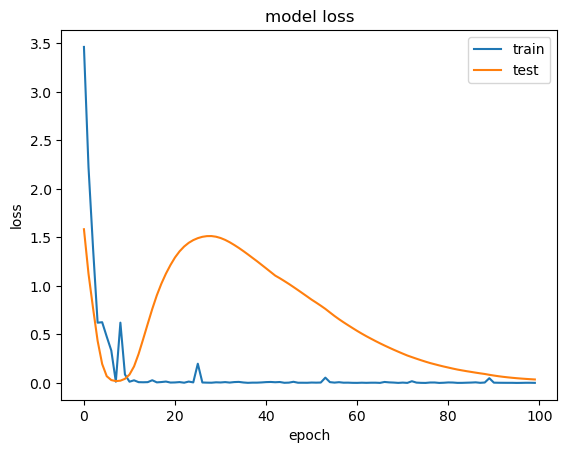

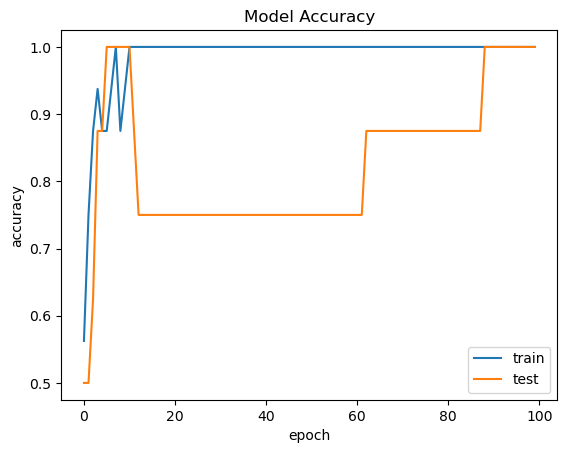

In [17]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

plot_history(history)